In [1]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import random

In [2]:
chroms = range(1, 23)

family_sizes = [3, 4, 5, 6]
phase_dir = '../phased'
data_dir = '../split_gen_miss'

#family_sizes = [4]
#phase_dir = '../phased_ssc'
#data_dir = '../split_gen_miss_ssc'

In [3]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [4]:
monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [8]:
family_to_chroms = defaultdict(set)
family_to_individuals = dict()
for chrom in chroms:
    print(chrom, end=' ')

    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                next(f) # skip header
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    family_to_chroms[family_key].add(chrom)
                    family_to_individuals[family_key] = pieces[1:(1+j)]
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'family size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)
            
families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
print('Families with all chroms', len(families_with_all_chroms))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 866


In [43]:
families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
print('Families with LCL', len(families_with_lcl))

families_to_include = [x for x in families_with_all_chroms if x.split('.')[0] in monozygotic_multiple_families and x not in families_with_lcl]
print('Final families', len(families_to_include))

Families with LCL 12
Final families 80


In [44]:
family = random.choice(families_to_include)
inds = family_to_individuals[family]
print(family)
print(inds)

AU1419.AU1419202.AU1419201
['AU1419202', 'AU1419201', 'AU1419302', 'AU1419301', 'AU1419303']


In [45]:
from collections import defaultdict

# load deletions from all chromosomes
states = []
positions = []

id_to_index = dict()
for chrom in chroms:
    print(chrom, end=' ')
    
    for j in family_sizes:
        try:
            with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header
                num_fams_of_size = 0
                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key == family:
                        id_to_index = dict([(x, i) for i, x in enumerate(pieces[1:(1+j)])])

            # load deletions
            family_to_states = defaultdict(list)
            family_to_pos = defaultdict(list)
            with open('%s/chr.%s.familysize.%d.phased.masked.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key == family:
                        inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                        positions.append((start_pos, end_pos))
                        
                        reordered_state = sum([inheritance_state[(2*id_to_index[ind]):((2*id_to_index[ind])+2)] for ind in inds], []) + [inheritance_state[-1]]
                        states.append(reordered_state)
                
        except FileNotFoundError:
            print('File not found', 'chrom', chrom, 'fammily size', j)
        except StopIteration:
            print('File empty', 'chrom', chrom, 'family size', j)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

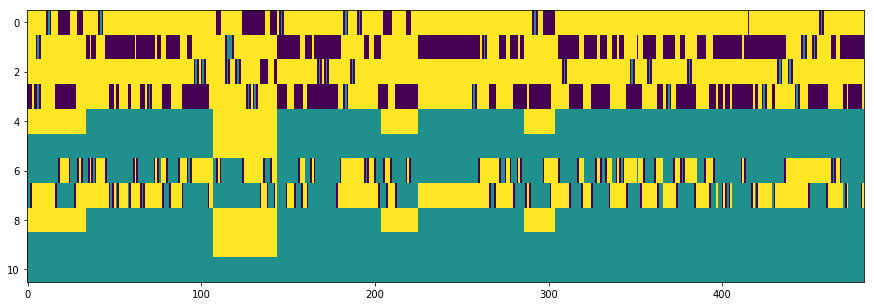

In [46]:
states = np.asarray(states).T

plt.figure(figsize=(15, 5))
plt.imshow(states[:, states[-1, :]==0], aspect='auto')
plt.show()